# Analyzer

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from skmisc.loess import loess

import statsmodels.api as sm
import statsmodels.formula.api as smf

import ipystata
from ipystata.config import config_stata  
config_stata('/Applications/Stata/StataMP.app/Contents/MacOS/stata-mp')  
from IPython.display import Image

In [3]:
PATH = "/Volumes/Extreme SSD/data/analysis"

df = pd.read_pickle(os.path.join(PATH, 'vendor_week.pickle'))

In [4]:
df.loc[df['price_diff_mw'].isin([np.inf]), 'price_diff_mw'] = None

In [5]:
df.columns

Index(['vendor', 'w', 'rating_m', 'reputation_m', 'price_usd_m', 'delta_t_m',
       'neg_rating_m', 'count_min', 'neg_count_min', 'pos_count_min',
       'price_usd_s', 'delta_t_s', 'cum_count', 'arf', 'arf_bgm', 'neg_rating',
       'international_shipment', 'item_count', 'item_count_w',
       'category_count', 'category_count_w', 'price_diff_mw', 'arm_maxw',
       'arm_bgm_maxw', 'empty_stock_last_week_maxw', 'm_maxw', 'rtime_dt_min',
       'neg_count_w', 'pos_count_w', 'has_price_drop'],
      dtype='object')

In [6]:
df['sales_volume_w'] = df.groupby('vendor').apply(lambda x: x['count_min'] - x['count_min'].shift(1)).fillna(10).reset_index(drop = True)

In [7]:
df['arm_maxw_shift'] = df.groupby('vendor').apply(lambda x: x['arm_maxw'].shift(1)).reset_index(drop = True).astype('bool')
df['arm_bgm_maxw_shift'] = df.groupby('vendor').apply(lambda x: x['arm_bgm_maxw'].shift(1)).reset_index(drop = True).astype('bool')
df['has_price_drop_shift'] = df.groupby('vendor').apply(lambda x: x['has_price_drop'].shift(1)).reset_index(drop = True).astype('bool')

In [8]:
shift = ['has_price_drop_shift', 'arm_bgm_maxw_shift', 'arm_maxw_shift']
df = df.dropna(subset = shift).reset_index(drop = True)

# Negative Feedbacks

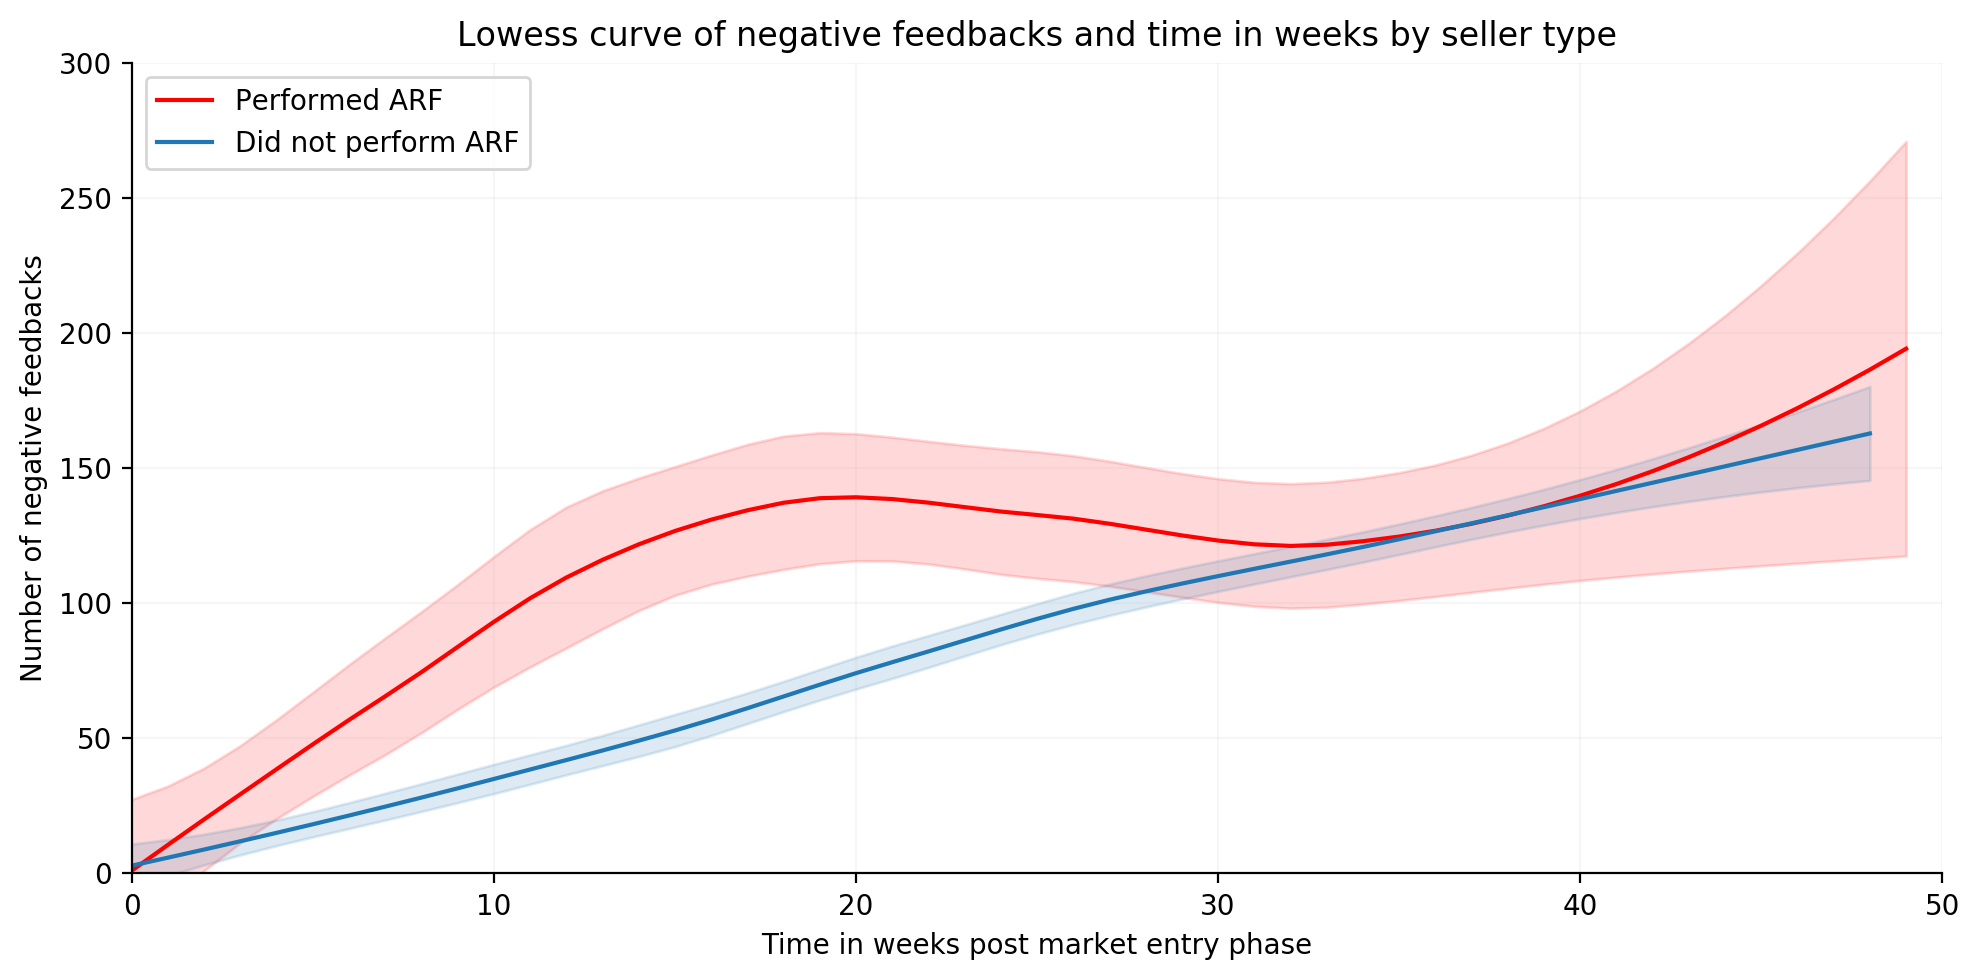

In [9]:
fig, ax = plt.subplots(figsize =  [10, 5])
ax.grid(True, which="both", ls="-", alpha = .1)

s = [df['arf'], ~df['arf']]
c = ['red', '#1f77b4']
l = ['Performed ARF', 'Did not perform ARF']

for selection, color, label in zip(s, c, l):
    # preprocess data
    data = df[selection].sort_values('w').copy()
    y = data['neg_count_min'].to_numpy()
    x = data['w'] - 2
    x_ = x.unique()

    # fit and predict lowess curve
    l = loess(x.to_numpy(), y, frac=0.1)
    l.fit()
    pred  = l.predict(x_, stderror=True)
    val   = pred.values
    conf  = pred.confidence()
    lower = conf.lower
    upper = conf.upper

    # plot lowess curve with 95% confidence
    ax.plot(x_, val, color=color, label = label)
    ax.fill_between(x_, lower, upper, alpha=.15, color=color)

ax.set_xlim(0, 50)
ax.set_ylim(0, 300)

# set titles and axes labels
ax.set_title('Lowess curve of negative feedbacks and time in weeks by seller type')
ax.set_ylabel('Number of negative feedbacks')
ax.set_xlabel('Time in weeks post market entry phase')
ax.legend(loc = 'upper left')

# show plot
plt.tight_layout()
plt.show()

In [10]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

# normalize variables
skewed_variables = ['neg_count_min', 'pos_count_min', 'item_count', 'count_min']

bc_vars = pd.DataFrame(
    pt.fit_transform(df[skewed_variables]),
    columns = ['bc_' + var for var in skewed_variables])

dummy_vars = df.assign(
        items   = pd.qcut(df['item_count'], 3,  labels=["low", "medium", "high"]),
        items_w = pd.qcut(df['item_count_w'], 3,  labels=["low", "medium", "high"]),
        sales   = pd.qcut(df['cum_count'], 2,  labels=["low", "high"]),
        sales_w = pd.qcut(df['sales_volume_w'], 2,  labels=["low", "high"]),
        q       = pd.cut(df.m_maxw, bins = 4, precision = 0, labels=['1', '2', '3', '4'])).loc[:,['items', 'items_w', 'q', 'sales', 'sales_w']]

bool_vars = df[
    ['arf', 'arf_bgm', 'arm_maxw', 'arm_maxw_shift', 'arm_bgm_maxw_shift',
     'international_shipment', 'has_price_drop', 'has_price_drop_shift']].astype('int')

lev_vars =  df[['vendor','w']]

data = pd.concat([lev_vars, bool_vars, bc_vars, dummy_vars], axis = 1)

In [11]:
data.columns

Index(['vendor', 'w', 'arf', 'arf_bgm', 'arm_maxw', 'arm_maxw_shift',
       'arm_bgm_maxw_shift', 'international_shipment', 'has_price_drop',
       'has_price_drop_shift', 'bc_neg_count_min', 'bc_pos_count_min',
       'bc_item_count', 'bc_count_min', 'items', 'items_w', 'q', 'sales',
       'sales_w'],
      dtype='object')

In [12]:
# Fit baseline model 
model0  = sm.OLS.from_formula("bc_neg_count_min ~ arf", data)
result0 = model0.fit()

# Fit a mixed model to data only with simple random intercept
# per week (used to to asses)
formula = ("bc_neg_count_min ~ arf")

model1  = sm.MixedLM.from_formula(formula, groups="w", data=data)
result1 = model1.fit()

# final model fixed effect of arf
formula = ("bc_neg_count_min ~ arf" 
           "+ international_shipment + C(items)"
           "+ C(sales) + bc_count_min + C(q)")

model2  = sm.MixedLM.from_formula(formula, groups="w", data=data)
result2 = model2.fit()

In [152]:
%%stata -d data

quietly {
* set output directory
cd "/Volumes/Extreme SSD/tabs"

* Fit Baseline Model on observations nested in weeks
qui: mixed bc_neg_count_min , nolrtest
eststo model0a

* Fit Variance Partition Model on observations nested in weeks
qui: mixed bc_neg_count_min || w: , nolrtest
eststo model1a
}
estat icc

quietly{
* Fit Fixed Effects Model on observations nested in weeks
qui: mixed bc_neg_count_min bc_pos_count_min international_shipment i.items i.sales c.bc_count_min i.q || w: , nolrtest
eststo model2a

* Fit Fixed Effects Model on observations nested in weeks
* With a random intercept of ARF
qui: mixed bc_neg_count_min c.arf bc_pos_count_min international_shipment i.items i.sales c.bc_count_min i.q || w: , nolrtest
eststo model3a
 
esttab using "neg_full_table.csv", b(3) se(3) wide nogaps nodepvars plain                    /// 
    order(_cons arf)                                                                         ///
    scalars(ll chi2 df_m N N_g) aic                                                          ///
    nonumbers mtitles("Model 0a" "Model 1a" "Model 2a" "Model 3a")                           ///
    coeflabels(_cons "Intercept" arf "ARF" bc_pos_count_min "Number of Positive Feedbacks"   ///
               international_shipment "International Shipment"                               ///
               0.items "Number of Items (ref.)" 1.items "   medium" 2.items "   high"        ///
               0.sales "Small Sellers (ref.)" 1.sales "Big Sellers"                          ///
               bc_count_min "Number of Sales" 0.q "Market Entry (ref.)" 1.q "   at Q2"       ///
               2.q "   at Q3" 3.q "   at Q4"  bc_neg_count_min ""                            ///
               lnsig_e  "Residual Variance Between Level"                                    ///
               lns1_1_1 "Residual Variance Within Level")                                    ///
    replace

esttab using "neg_fit_table.csv", cells(none) wide nogaps nodepvars plain                    /// 
    scalars(ll chi2 df_m N N_g) aic                                                          ///
    nonumbers mtitles("Model 0a" "Model 1a" "Model 2a" "Model 3a")                           ///
    replace
    
esttab using "neg_fit_table.rtf", cells(none) wide nogaps nodepvars plain compress           /// 
    scalars(ll chi2 df_m N N_g) aic                                                          ///
    nonumbers mtitles("Model 0a" "Model 1a" "Model 2a" "Model 3a")                           ///
    replace
}


Intraclass correlation

------------------------------------------------------------------------------
                       Level |        ICC   Std. Err.     [95% Conf. Interval]
-----------------------------+------------------------------------------------
                           w |   .2175967   .0345742      .1573925    .2928265
------------------------------------------------------------------------------


# ARM

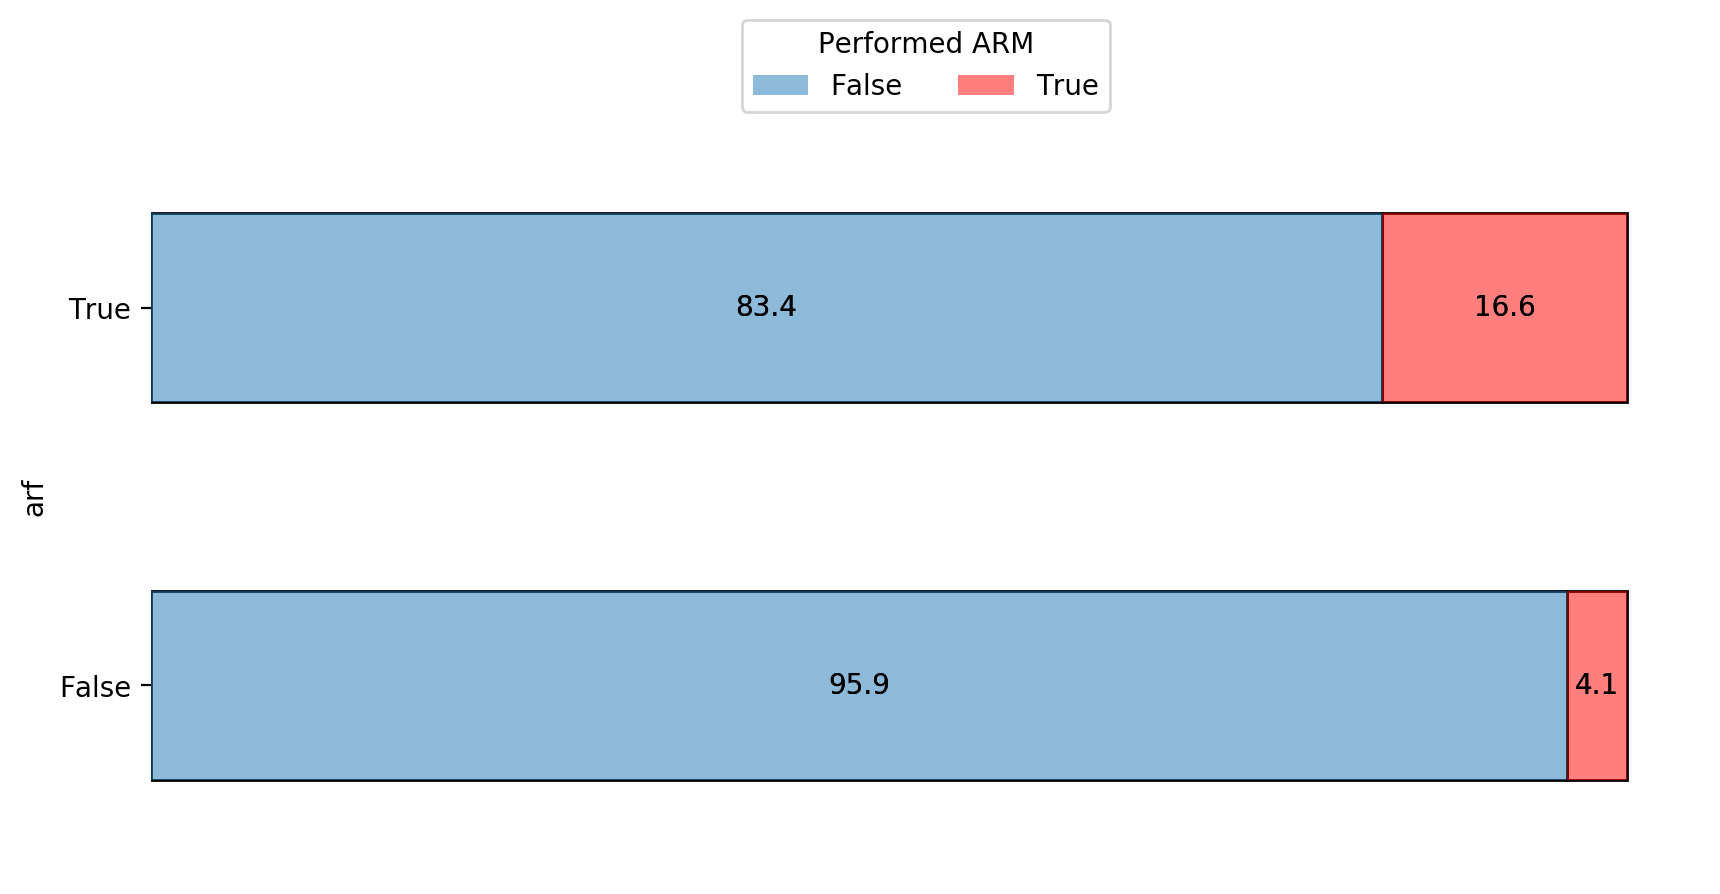

In [14]:
ct = pd.crosstab(df['arf'], df['arm_maxw'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ax.invert_yaxis()

ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5) 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), 
          loc='upper center', bbox_to_anchor=(0.5, 1.15), 
          ncol = 2, title = 'Performed ARM')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.show()

In [151]:
%%stata -d data

quietly{
* set output directory
cd "/Volumes/Extreme SSD/tabs"

* Fit Fixed Effects Model on observations nested in vendors
qui: melogit arm_maxw_shift
eststo model0b

* Fit Fixed Effects Model on observations nested in vendors
qui: melogit arm_maxw_shift                    || vendor:
eststo model1b
}
estat icc

quietly{
* Fit Fixed Effects Model on observations nested in vendors
qui: melogit arm_maxw_shift                                       ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*           ///
        international_shipment has_price_drop  || vendor:
eststo model2b

* Fit Fixed Effects Model on observations nested in vendors
* With a random intercept of negative feedbacks
qui: melogit arm_maxw_shift c.bc_neg_count_min c.arf              ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*           ///
        international_shipment has_price_drop  || vendor:
eststo model3b

* Fit Random Effects Model on observations nested in vendors
* With a random intercept and random slope of negative feedbacks
qui: melogit arm_maxw_shift c.bc_neg_count_min c.arf              ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*           ///
        international_shipment has_price_drop  || vendor: R.bc_neg_count_min, cov(un)
eststo model4b

* Fit Random Effects Model on observations nested in vendors
* With a random intercept and random slope of negative feedbacks
* and cross-level interaction
qui: melogit arm_maxw_shift c.bc_neg_count_min##c.arf             ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*           ///
        international_shipment has_price_drop  || vendor: R.bc_neg_count_min, cov(un)
eststo model5b

esttab using "arm_full_table.csv", b(3) se(3) wide nogaps nodepvars plain                    ///
    order(_cons bc_neg_count_min arf bc_neg_count_min#arf)                                   ///  
    scalars(ll chi2 df_m N N_g) aic                                                          ///
    nonumbers mtitles("Model 0b" "Model 1b" "Model 2b" "Model 3b" "Model4b" "Model5b")       ///
    coeflabels(_cons "Intercept" bc_neg_count_min "Number of Negative Feedbacks"             ///
               arf "ARF" bc_pos_count_min "Number of Positive Feedbacks"                     ///
               international_shipment "International Shipment"                               ///
               c.bc_neg_count_min#c.arf "Number of Negative Feedbacks * ARF"                 ///
               0.items_w "Number of Items per week (ref.)" 1.items_w "   medium"             ///
               2.items_w "   high"  0.sales_w "Small Sellers that week (ref.)"               ///
               1.sales_w "Big Sellers" bc_count_min "Number of Sales per start of week"      ///
               0.q "Market Entry (ref.)" 1.q "   at Q2" 2.q "   at Q3"                       ///
               3.q "   at Q4"  has_price_drop "Has Price Drop"                               ///
               var(_cons[vendor]) "Residual Variance Between level"                          ///
               var(_cons[vendor>bc_neg_count_min]) "Residual Variance Between level")        ///
    replace
 
esttab using "arm_fit_table.csv", cells(none) wide nogaps nodepvars plain                    /// 
    scalars(ll chi2 df_m) aic                                                                ///
    nonumbers mtitles("Model 0b" "Model 1b" "Model 2b" "Model 3b" "Model 4b" "Model 5b")     ///
    replace

esttab using "arm_fit_table.rtf", cells(none) wide nogaps nodepvars plain compress           /// 
    scalars(ll chi2 df_m) aic                                                                ///
    nonumbers mtitles("Model 0b" "Model 1b" "Model 2b" "Model 3b" "Model 4b" "Model 5b")     ///
    replace
          
}


Intraclass correlation

------------------------------------------------------------------------------
                       Level |        ICC   Std. Err.     [95% Conf. Interval]
-----------------------------+------------------------------------------------
                      vendor |   .2646145   .0132719       .239432    .2914309
------------------------------------------------------------------------------


# Selling Price Adjustment

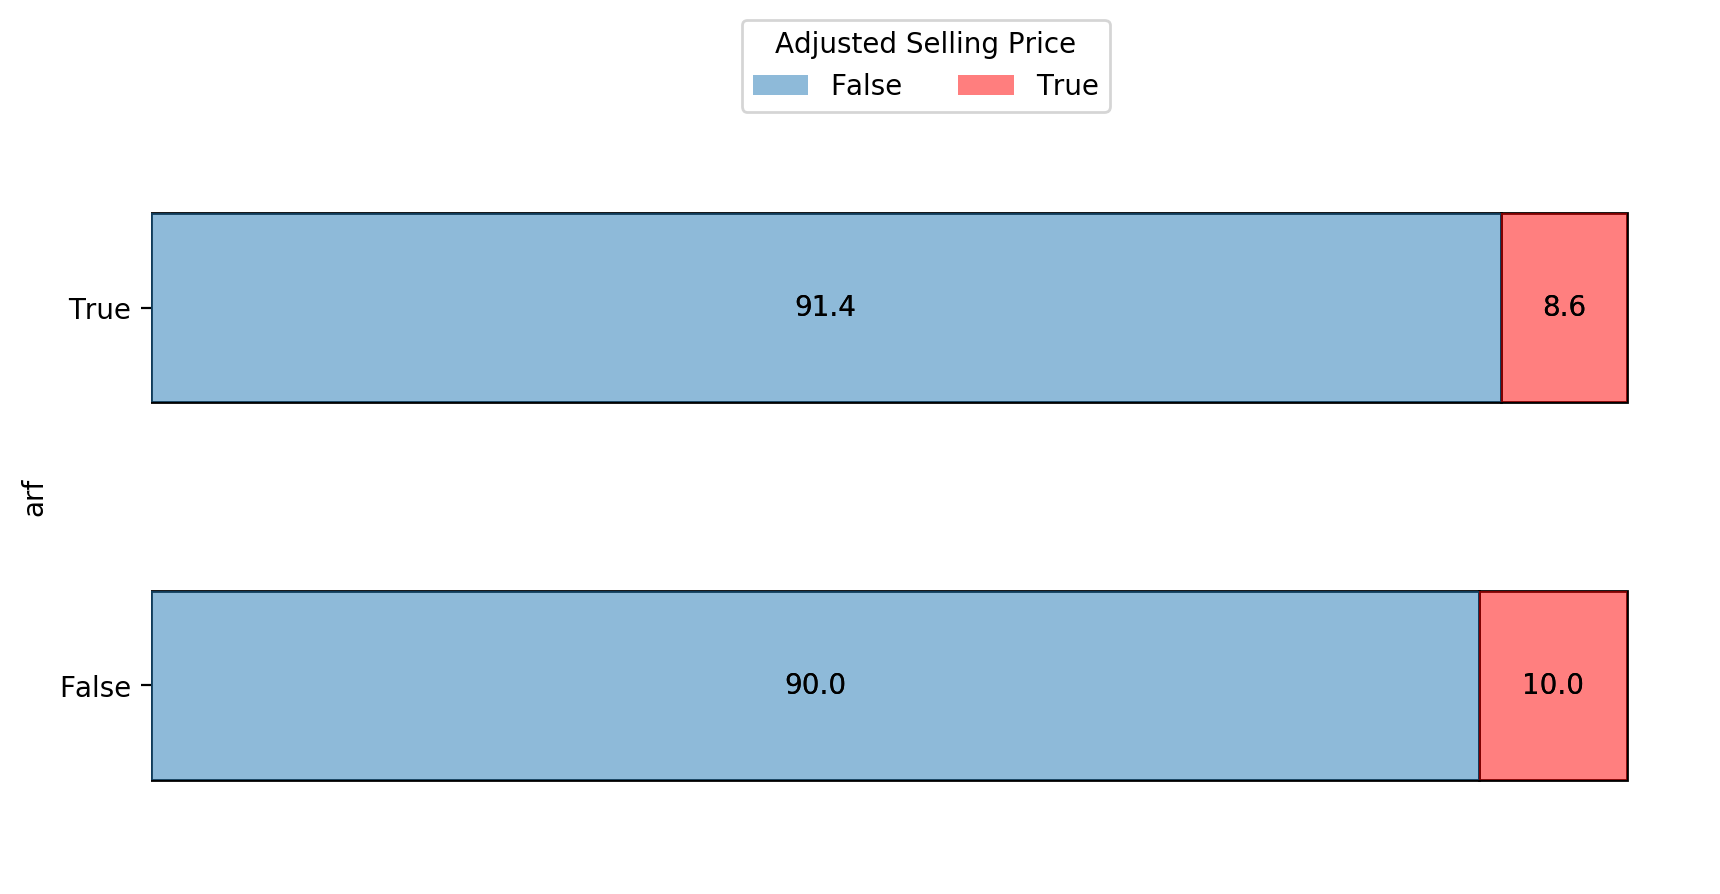

In [16]:
ct = pd.crosstab(df['arf'], df['has_price_drop'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5)
ax.invert_yaxis() 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol = 2, title = 'Adjusted Selling Price')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')
        
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.invert_yaxis()
plt.xticks([])
plt.show()

In [153]:
%%stata -d data

quietly{
* set output directory
cd "/Volumes/Extreme SSD/tabs"

* Fit Fixed Effects Model on observations nested in vendors
qui: melogit has_price_drop_shift
eststo model0c

* Fit Fixed Effects Model on observations nested in vendors
qui: melogit has_price_drop_shift        || vendor:
eststo model1c
}
estat icc

quietly{
* Fit Fixed Effects Model on observations nested in vendors
qui: melogit has_price_drop_shift                                       ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*                 ///
        international_shipment arm_maxw  || vendor:
eststo model2c

* Fit Fixed Effects Model on observations nested in vendors
* With a random intercept of negative feedbacks
qui: melogit has_price_drop_shift c.bc_neg_count_min c.arf              ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*                 ///
        international_shipment arm_maxw  || vendor:
eststo model3c

* Fit Random Effects Model on observations nested in vendors
* With a random intercept and random slope of negative feedbacks
qui: melogit has_price_drop_shift c.bc_neg_count_min c.arf              ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*                 ///
        international_shipment arm_maxw  || vendor: R.bc_neg_count_min, cov(un)
eststo model4c

* Fit Random Effects Model on observations nested in vendors
* With a random intercept and random slope of negative feedbacks
* and cross-level interaction
qui: melogit has_price_drop_shift c.bc_neg_count_min##c.arf             ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*                 ///
        international_shipment arm_maxw  || vendor: R.bc_neg_count_min, cov(un)
eststo model5c

esttab using "price_full_table.csv", b(3) se(3) wide nogaps nodepvars plain                  ///
    order(_cons bc_neg_count_min arf bc_neg_count_min#arf)                                   ///  
    scalars(ll chi2 df_m) aic                                                                ///
    nonumbers mtitles("Model 0c" "Model 1c" "Model 2c" "Model 3c" "Model4c" "Model5c")       ///
    coeflabels(_cons "Intercept" bc_neg_count_min "Number of Negative Feedbacks"             ///
               arf "ARF" bc_pos_count_min "Number of Positive Feedbacks"                     ///
               c.bc_neg_count_min#c.arf "Number of Negative Feedbacks * ARF"                 ///
               international_shipment "International Shipment"                               ///
               0.items_w "Number of Items per week (ref.)" 1.items_w "   medium"             ///
               2.items_w "   high"  0.sales_w "Small Sellers that week (ref.)"               ///
               1.sales_w "Big Sellers" bc_count_min "Number of Sales per start of week"      ///
               0.q "Market Entry (ref.)" 1.q "   at Q2" 2.q "   at Q3"                       ///
               3.q "   at Q4"  arm_maxw "ARM")                                               ///
    replace

esttab using "price_fit_table.csv", cells(none) wide nogaps nodepvars plain                  /// 
    scalars(ll chi2 df_m N N_g) aic                                                          ///
    nonumbers mtitles("Model 0c" "Model 1c" "Model 2c" "Model 3c" "Model 4c" "Model 5c")     ///
    replace
          
esttab using "price_fit_table.rtf", cells(none) wide nogaps nodepvars plain compress         /// 
    scalars(ll chi2 df_m N N_g) aic                                                          ///
    nonumbers mtitles("Model 0c" "Model 1c" "Model 2c" "Model 3c" "Model 4c" "Model 5c")     ///
    replace
}
          


Intraclass correlation

------------------------------------------------------------------------------
                       Level |        ICC   Std. Err.     [95% Conf. Interval]
-----------------------------+------------------------------------------------
                      vendor |   .0188271     .00536      .0107488    .0327755
------------------------------------------------------------------------------


In [148]:
%%stata -d data

* set output directory
cd "/Volumes/Extreme SSD/tabs"

* Fit Fixed Effects Model on observations nested in weeks
* With a random intercept of ARF
mixed bc_neg_count_min c.arf bc_pos_count_min                       ///
        international_shipment i.items i.sales                           ///
        c.bc_count_min i.q || w: , nolrtest
eststo model3a

* Fit Random Effects Model on observations nested in vendors
* With a random intercept and random slope of negative feedbacks
* and cross-level interaction
melogit arm_maxw_shift c.bc_neg_count_min##c.arf                    ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*                  ///
        international_shipment has_price_drop  || vendor: R.bc_neg_count_min, cov(un)
eststo model5b

* Fit Random Effects Model on observations nested in vendors
* With a random intercept and random slope of negative feedbacks
* and cross-level interaction
melogit has_price_drop_shift c.bc_neg_count_min##c.arf             ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*                 ///
        international_shipment arm_maxw  || vendor: R.bc_neg_count_min, cov(un)
eststo model5c

esttab model3a model5b model5c using "slim_reg_table.rtf", b(3) se(3) wide nogaps nodepvars compress noparentheses   ///
    order(_cons bc_neg_count_min arf bc_neg_count_min#arf)                                   ///  
    scalars(ll chi2 df_m N_g) aic                                                            ///
    nonumbers mtitles("Model 3a" "Model 5b" "Model 5c")                                      ///
    coeflabels(_cons "Intercept" bc_neg_count_min "Number of Negative Feedbacks"             ///
               arf "ARF" bc_pos_count_min "Number of Positive Feedbacks"                     ///
               c.bc_neg_count_min#c.arf "Number of Negative Feedbacks * ARF"                 ///
               international_shipment "International Shipment"                               ///
               0.items "Number of Items (ref.)" 1.items "   medium" 2.items "   high"        ///
               0.sales "Small Sellers (ref.)" 1.sales "Big Sellers"                          ///
               0.items_w "Number of Items per week (ref.)" 1.items_w "   medium"             ///
               2.items_w "   high"  0.sales_w "Small Sellers that week (ref.)"               ///
               1.sales_w "Big Sellers" bc_count_min "Number of Sales per start of week"      ///
               0.q "Market Entry (ref.)" 1.q "   at Q2"                                      ///
               2.q "   at Q3" 3.q "   at Q4"  arm_maxw "ARM")                                ///
    replace



. cd "/Volumes/Extreme SSD/tabs"
/Volumes/Extreme SSD/tabs
. * With a random intercept of ARF>         international_shipment i.items i.sales                           ///
>         c.bc_count_min i.q || w: , nolrtest

Performing EM optimization: 

Performing gradient-based optimization: 

Iteration 0:   log likelihood = -24496.181  
Iteration 1:   log likelihood = -24496.181  

Computing standard errors:

Mixed-effects ML regression                     Number of obs     =     24,551
Group variable: w                               Number of groups  =         51

                                                Obs per group:
                                                              min =          1
                                                              avg =      481.4
                                                              max =        912

                                                Wald chi2(10)     =   19132.48
Log likelihood = -24496.181                     Pr

In [ ]:
foreach var of varlist d_*{
    mixed `var' || vendor:
}
                          
ttest d_x4_p, by(arf)
ttest d_x4_a, by(arf)

In [154]:
%%stata -d data -o output

quietly{
* set output directory
cd "/Volumes/Extreme SSD/tabs"

qui: melogit has_price_drop_shift c.bc_neg_count_min##c.arf             ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*                 ///
        international_shipment arm_maxw  || vendor: R.bc_neg_count_min, cov(un)

//# marginal efffects calculated manually bc estimation problem
predict p 
gen ame = p*(1-p)
gen d_x1_p = ame*_b[bc_neg_count_min]
gen d_x2_p = ame*_b[arf]
gen d_x3_p = ame*_b[c.bc_neg_count_min#c.arf]
gen d_x4_p = d_x1_p + d_x2_p + d_x3_p
                        
qui: melogit arm_maxw_shift c.bc_neg_count_min##c.arf             ///
        bc_pos_count_min c.w i.q* i.items_w* i.sales_w*                 ///
        international_shipment arm_maxw  || vendor: R.bc_neg_count_min, cov(un)

//# marginal efffects calculated manually bc estimation problem
predict p2 
gen ame2 = p2*(1-p2)
gen d_x1_a = ame2*_b[bc_neg_count_min]
gen d_x2_a = ame2*_b[arf]
gen d_x3_a = ame2*_b[c.bc_neg_count_min#c.arf]
gen d_x4_a = d_x1_a + d_x2_a + d_x3_a


mixed ame2 c.bc_neg_count_min##c.arf bc_pos_count_min c.w i.q* i.items_w* i.sales_w* international_shipment arm_maxw|| vendor: 
eststo 
mixed ame c.bc_neg_count_min##c.arf bc_pos_count_min c.w i.q* i.items_w* i.sales_w* international_shipment arm_maxw|| vendor:
eststo
}

esttab, b(3) se(3) wide nogaps nodepvars compress noparentheses


--------------------------------------------------------
                 (1)                    (2)             
                est1                   est2             
--------------------------------------------------------
main                                                    
bc_neg_c~n     0.013***     0.000     0.013***     0.000
arf            0.020***     0.004     0.014***     0.001
c.bc_neg~f     0.016***     0.001    -0.001        0.001
bc_pos_c~n    -0.057***     0.001    -0.066***     0.000
w              0.000***     0.000    -0.001***     0.000
0.q            0.000            .     0.000            .
1.q           -0.010***     0.002    -0.035***     0.001
2.q            0.004        0.003    -0.044***     0.001
3.q            0.037***     0.003    -0.025***     0.001
0.items_w      0.000            .     0.000            .
1.items_w     -0.000        0.001     0.002***     0.000
2.items_w      0.045***     0.001     0.014***     0.000
0.sales_w      0.000          

In [143]:
output.sort_values(['bc_neg_count_min', 'vendor'])
output['neg_c'] = output.groupby('vendor')['bc_neg_count_min'].transform(lambda x: (x - x.min())/(x - x.min()).max())

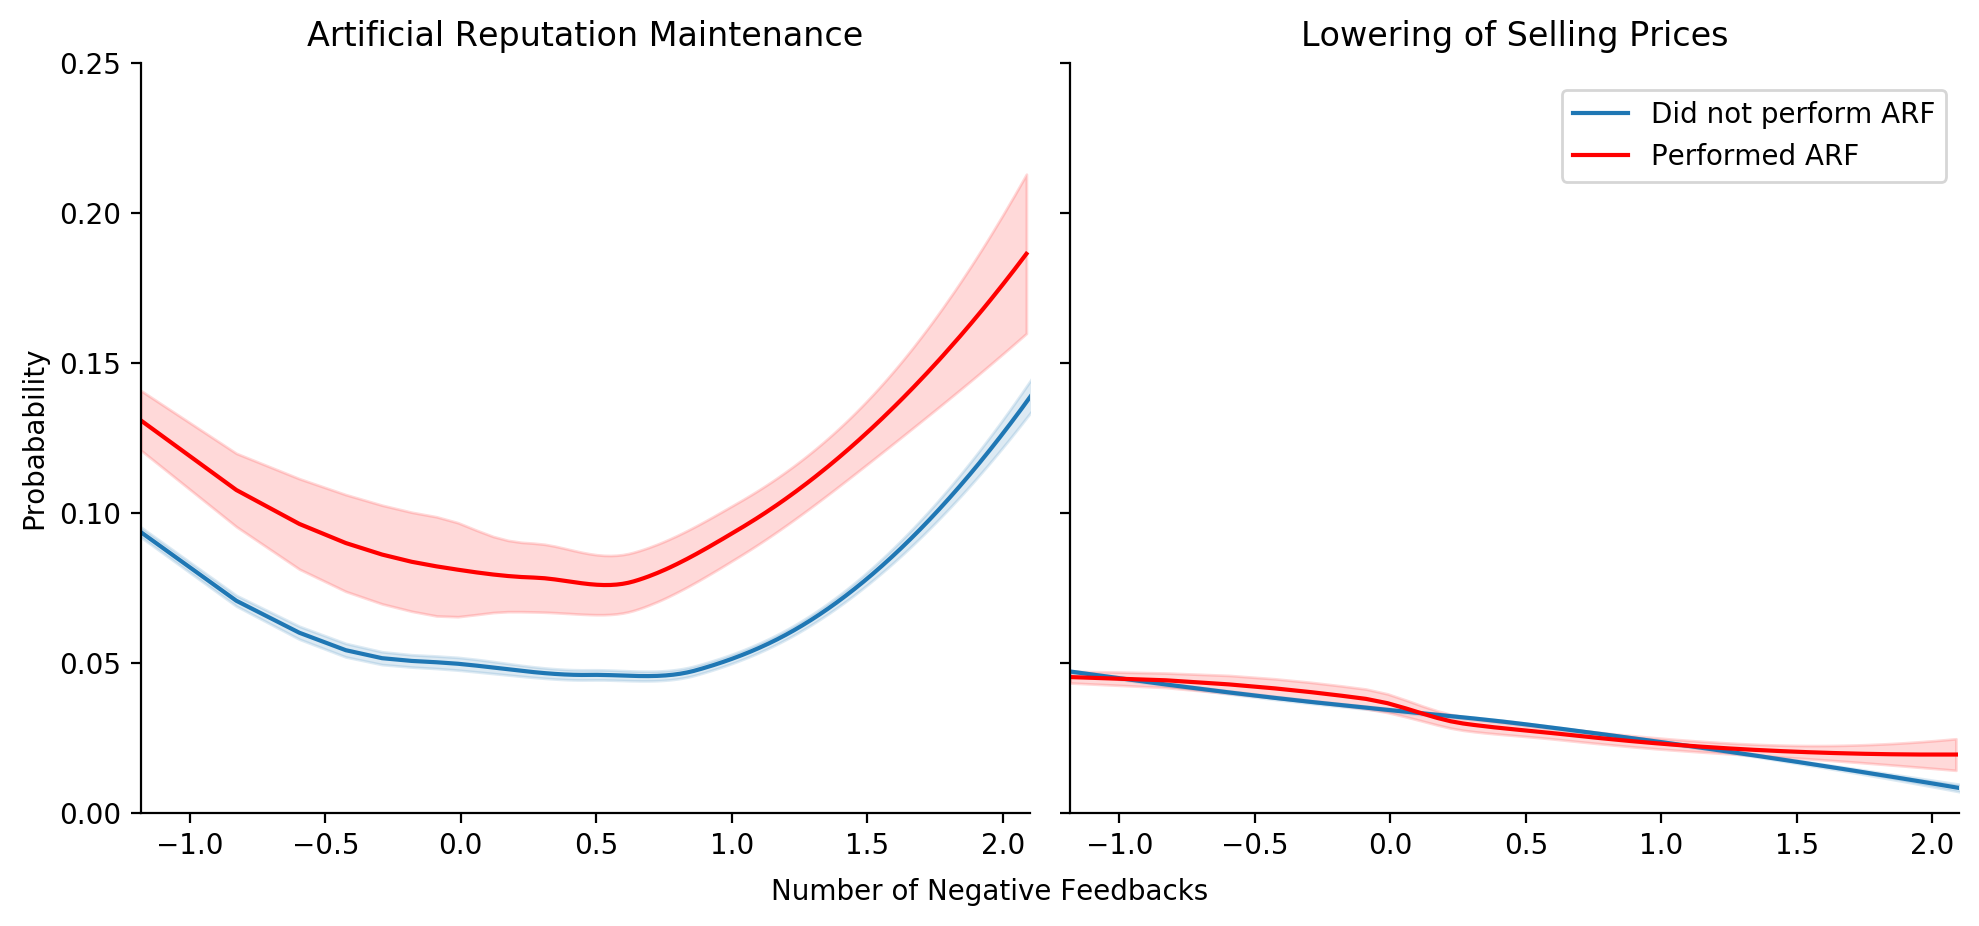

In [147]:
fig, (axes) = plt.subplots(ncols = 2, figsize =  [10, 5], sharey = True)

# make margin plots
for t in [0,1]:
    arf_type = output['arf'] == t
    color = ['#1f77b4', 'red']
    label = ['Did not perform ARF', 'Performed ARF']
    title = ['Artificial Reputation Maintenance', 'Lowering of Selling Prices']
    minx, maxx = np.min(output.bc_neg_count_min), 2.1
    
    for i, y_var in enumerate(['d_x4_a', 'd_x4_p']):
        # preprocess data
        d_ = output[arf_type]
        y = d_[y_var].to_numpy()
        x = d_['bc_neg_count_min']
        x_ = x.sort_values().unique()

        # fit and predict lowess curve
        l = loess(x.to_numpy(), y)
        l.fit()
        pred  = l.predict(x_, stderror=True)
        val   = pred.values
        conf  = pred.confidence()
        lower = conf.lower
        upper = conf.upper

        # plot lowess curve with 95% confidence
        axes[i].plot(x_, val, c = color[t], label = label[t])
        axes[i].fill_between(x_, lower, upper, alpha=.15, color=color[t])
        
        # set axes and titles
        axes[i].set_ylim(0, .25)
        axes[i].set_xlim(minx, maxx)
        axes[i].set_title(title[i])

# set labels  
axes[0].set_ylabel('Probabability')
fig.text(0.5, 0.04, 'Number of Negative Feedbacks', ha='center')
# fig.suptitle('Average Marginal Effects with 95%CI', fontsize=16)

# set legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.98, .85))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [74]:
temp = pd.concat([df['neg_count_min'], round(temp['bc_neg_count_min'], 2)], axis = 1)
print(temp.loc[temp['bc_neg_count_min'].between(.2, .22), 'neg_count_min'].mean())
print(temp.loc[temp['bc_neg_count_min'].between(-.09, -.06), 'neg_count_min'].mean())
print(temp.loc[temp['bc_neg_count_min'].between(-.01, .01), 'neg_count_min'].mean())

12.0
7.0
8.0
